### Deep Learning Notes 2
- *Автор*: Зитцер Данил
- *Дата*: вторник, 26 января 2021 г., 08:52:14
- *Описание*: Пошаговое объяснение градиентного спуска. Благодаря ему нейронные сети способны учиться.
- *План блокнота*:
    1. Постановка задачи
        - описание данных
        - задание целевой функции
    2. Введение в градиентный спуск
        - визуализация целевой функции
        - описание сути градиетного спуска
        - шаг градиентного спуска
        - осуществлени нескольких шагов ГС
        - визуализация ГС
        - проверка полученного решения
    3. Способы вычисления градиентов в TensorFlow
        - ручное дифференцирование
        - конечно-разностное приближение
        - Автоматическое дифференцирование в обратном порядке
    4. Линейная регрессия
        - в TensorFlow
        - в Keras
    5. Модификации ГС
        - визуализация модификаций ГС

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import Image
from typing import Optional


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 20

Схема обучения нейронных сетей:

![](https://drek4537l1klr.cloudfront.net/allaire/v-1/Figures/deep-learning-in-3-figures-3.png)

### Постановка задачи

 Имеется три точки на плоскости. Требуется провести прямую линию максимально близко лежащую к всем точкам сразу. Такого рода задачи называются задачами регрессии.

#### Описание данных 

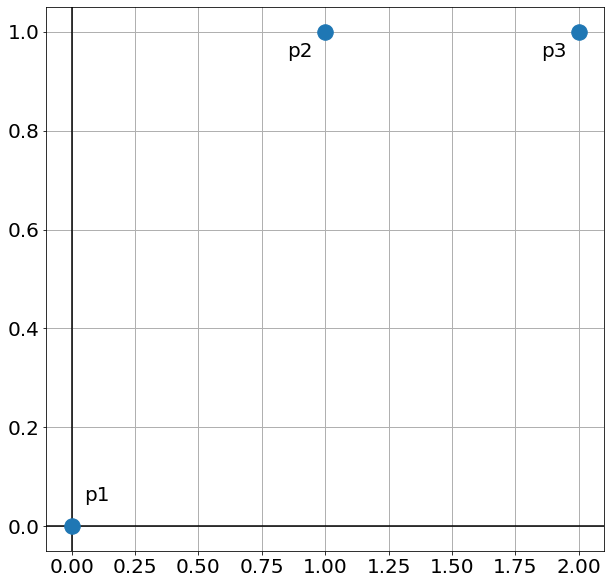

In [2]:
x = np.array([[0.], [1.], [2.]])  # x-координаты точек
y = np.array([[0.], [1.], [1.]])  # y-координаты точек

plt.scatter(x, y, marker='o', s=20*4*3, zorder=3)
plt.grid(linestyle='-', linewidth='1.0')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.annotate('p1', (0.05, 0.05))
plt.annotate('p2', (0.85, 0.95))
plt.annotate('p3', (1.85, 0.95))

plt.show()

Пример регресионной задачи из реальной жизни. Оценить влияние скорости бега и скорости езды на велосипеде на пульс спортсмена.

![](../pics/01_linear_regression_real_problem.jpg)

У нас имеется множество вариантов, чтобы провести прямую линию. Какой из вариантов выбрать?

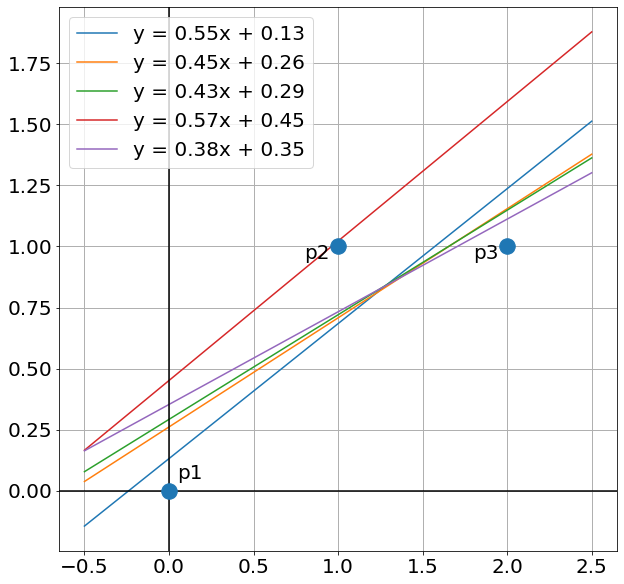

In [3]:
x_axis = np.linspace(-0.5, 2.5, 100)

for i in range(5):
    slope = np.random.uniform(low=0.3, high=0.6)
    intercept = np.random.uniform(low=0.1, high=0.5)
    
    plt.plot(
        x_axis,
        np.vectorize(lambda x: slope*x + intercept)(x_axis),
        label=f'y = {slope:.2f}x + {intercept:.2f}',
    )

plt.scatter(x, y, marker='o', s=20*4*3, zorder=3)
plt.grid(linestyle='-', linewidth='1.0')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.legend(loc='upper left')

plt.annotate('p1', (0.05, 0.05))
plt.annotate('p2', (0.80, 0.95))
plt.annotate('p3', (1.80, 0.95))
    
plt.show()

#### Задание целевой функции

Давайте проведём прямую горизонтальную линию и посчитаем сумму расстояний от каждой из точек до этой прямой.

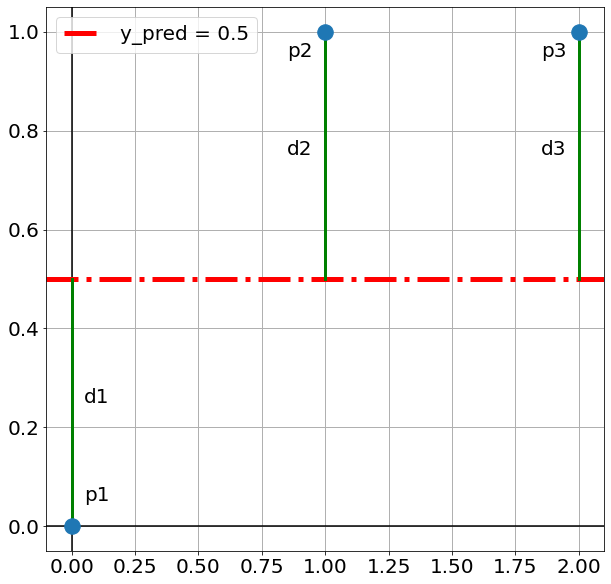

In [4]:
plt.scatter(x, y, marker='o', s=20*4*3, zorder=3)
plt.grid(linestyle='-', linewidth='1.0')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.axhline(0.5, color='red', ls='-.', lw=5, label='y_pred = 0.5')

plt.plot([0, 0], [0, 0.5], 'g', lw=3)
plt.plot([1, 1], [0.5, 1.0], 'g', lw=3)
plt.plot([2, 2], [0.5, 1.0], 'g', lw=3)

plt.legend(loc='upper left')

plt.annotate('d1', (0.05, 0.25))
plt.annotate('d2', (0.85, 0.75))
plt.annotate('d3', (1.85, 0.75))

plt.annotate('p1', (0.05, 0.05))
plt.annotate('p2', (0.85, 0.95))
plt.annotate('p3', (1.85, 0.95))

plt.show()

$$\Large d_1 = y_{pred} - y_{true}^1 = 0.5 - 0.0 = 0.5$$
$$\Large d_2 = y_{pred} - y_{true}^2 = 0.5 - 1.0 = -0.5$$
$$\Large d_3 = y_{pred} - y_{true}^3 = 0.5 - 1.0 = -0.5$$

$$\Large distance = \sum \limits_{i=1}^{3} d_i = 0.5 + (-0.5) + (-0.5) = 0.5$$

Как мы видим, некоторые расстояния могут занулить друг друга. Из-за этого в какой-то момент мы получим в сумме ноль, но это не будет значить, что прямая линия проходит через каждую из точек. Для избежания возведём расстояния в квадрат.

$$\Large distance = \sum \limits_{i=1}^{3} d_i^2 = 0.5^2 + (-0.5)^2 + (-0.5)^2 = 0.75$$

В общем виде уравнение будет выглядить вот так:

$$\Large distance = \sum \limits_{i=1}^{3} (y_{pred} - y_{true})^2 \to \min$$

Так как мы проводим именно прямую линию, то её уравнение имеет вид:

$$\Large y(x) = a \cdot x + b$$

Подставим вместо $\large y_{pred}$ уравнение прямой линии и упростим выражение (вместо x и y подставим координаты исходных точек):

$$\Large distance = \sum \limits_{i=1}^{3} (y_{pred}(x_i) - y_{true}^i)^2 = \\
  \Large = \sum \limits_{i=1}^{3} ((a \cdot x_i + b) - y_{true}^i)^2 = \\
  \Large = ((a \cdot x_1 + b) - y_1)^2 + ((a \cdot x_1 + b) - y_1)^2 + ((a \cdot x_1 + b) - y_1)^2 = \\
  \Large = ((a \cdot 0 + b) - 0)^2 + ((a \cdot 1 + b) - 1)^2 + ((a \cdot 2 + b) - 1)^2 = \\
  \Large = b^2 + (a + b - 1)^2 + (2a + b - 1)^2 = \\
  \Large = b^2 + a^2 + b^2 + 1 + 2ab - 2a - 2b + 4a^2 + b^2 + 1 + 4ab - 4a - 2b = \\
  \Large = 5a^2 + 3b^2 -6a - 4b + 6ab + 2$$

В итоге мы получили функцию, зависящую только от параметров прямой линии:
- a - угол наклона прямой
- b - смещение прямой по оси Y

С визуализацией прямых линий можно поиграться вот [здесь](https://www.desmos.com/calculator/wqlnokf03o).

Функция, требующая минимизации:

$$ \Large f(a, b) = 5a^2 + 3b^2 -6a - 4b + 6ab + 2 \to \min$$

### Введение в градиентный спуск (далее ГС)

#### Визуализация ГС

[3D-график целевой функции, требующей минимизации](https://academo.org/demos/3d-surface-plotter/?expression=5*x*x%2B3*y*y-6*x-4*y%2B6*x*y%2B2&xRange=-1%2C%2B1&yRange=-1%2C%2B1&resolution=57)

[Целевая функция (до раскрытия скобок) на WolframAlpha](https://www.wolframalpha.com/input/?i=b%5E2+%2B+%28a+%2B+b+-+1%29%5E2+%2B+%282*a+%2B+b+-+1%29%5E2)

![](https://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization_files/ball.png)

Градиентный спуск опирается на понятие производной. Попробую показать важность производной в письменной форме:

Пусть есть некая функция, допустим $f(x) = x^2$

$$ \Large f(x) = x^2 $$

Производная - это предел приращения функции к приращению аргумента. Запишем это:

$$ \Large f'(x_0) = \lim_{x \to x_0} \frac{f(x) - f(x_0)}{x - x_0} $$

Так как у нас $x$ максимально близко приближается к $x_0$, то можно убрать знак предела и поставить знак приблизительного равенства:

$$ \Large f'(x_0) \approx \frac{f(x) - f(x_0)}{x - x_0} $$

Теперь из этого приблизительного равенства выразим нашу функцию $f(x)$:

$$ \Large f'(x_0)(x - x_0) \approx f(x) - f(x_0) $$

$$ \Large f(x) \approx f(x_0) + f'(x_0)(x - x_0) $$

**Внимание!** Мы получили аппроксимацию нашей исходной функции некой линейной функцией в районе точки $x_0$.

Подставим в приблизительное равенство известные нам значения:
- $f(x) = x^2$ - исходная функция
- $f'(x) = 2x$ - её производная
- $x_0 = 2$ - наша отправная точка (выбрана случайно)
- $f(x_0) = f(2) = 4$ - значение исходной функции в $x_0$
- $f'(x_0) = f'(x_0) = 4$ - значение производной функции в $x_0$

$$ \Large x_0 = 2 $$

$$ \Large f(x) \approx f(2) + f'(2)(x - 2) $$

$$ \Large f(x) \approx 4x - 4 \space \text{вблизи }x_0 = 2$$

$$ \Large f(x) \approx 4x - 4 \to min \space \text{вблизи }x_0 = 2$$

Теперь следите за ходом мысли:
- у нас была некая функция $f(x) = x^2$
- в области точки $x_0 = 2$ мы получили что $x^2 \approx 4x - 4$, **но это только вблизи точки $x_0 = 2$**
- мы хотим минимизировать функцию $f(x) = x^2$ (будем называть её целевой функцией)
- в качестве целевой выбрана довольно простая функция, гораздо чаще функции бывают намного сложнее
- так вот благодаря аппроксимации в районе некоторой точки мы можем легко понять в какую сторону нам необходимо изменить переменную, чтобы целевая функция уменьшилась
- в районе точки $x_0$ целевая функция $f(x) = x^2$ ведёт себя очень схожим образом с линейной функцией $f(x) = 4x -4$
- с линейной функцией $f(x) = 4x -4$ всё просто: увеличение $x$ ведёт к увеличению функции. Понять это можно по знаку коэффициента перед $x$, то есть 4
- так как мы хотим минизировать, то нам следовательно нужно не увеличивать $x$, а уменьшать
- значит уменьшение $x$ приведёт к уменьшению целевой функции $f(x) = x^2$
- изначально $x_0 = 2$, в следующий раз нам стоит взять, например, $x_1 = 1.9$

Теперь более сухим языком:
- геометрический смысл производной в точке - это тангенс угла наклона касатаельной к графику функции в той же точке
- производная функции одной переменной даёт нам градиент функции
- знак градиента показывает нам направление изменения переменной для наискорейшего возрастания функции
- если мы хотим минимизировать функцию, то соответственно, нам следует совершать изменение переменной в сторону противоположную градиенту
- именно поэтому метод называется градиентным спуском

[Градиентный спуск на Wiki](https://ru.wikipedia.org/wiki/%D0%93%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D1%83%D1%81%D0%BA)

![](https://miro.medium.com/max/1200/1*N5WjbzwsCFse-KPjBWZZ6g.jpeg)

![](https://upload.wikimedia.org/wikipedia/ru/c/cc/%D0%93%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82_%D1%85%D0%BE%D0%BB%D0%BC%D0%B0.gif)

Ещё одно интересное свойство градиента - он всегда противоположен линиям уровня.

![](https://hplgit.github.io/primer.html/doc/pub/plot/fig-plot/quiver_matplotlib_advanced.png)

![](https://blog.paperspace.com/content/images/2019/09/F1-02.large.jpg)

#### Шаги ГС

Вернёмся к исходной задаче. Наша целевая функция:

$$ \Large f(a, b) = 5a^2 + 3b^2 -6a - 4b + 6ab + 2 \to \min$$

Перевёрнутый треугольник - это обозначение градиента функции, читается как набла.

Для совершения одного шага нужно посчитать градиент функции по выбраннаму параметру в конкретной точке.

$$ \Large a_{next} = a_{curr} - \alpha \nabla f(a_{curr}) \hspace{20mm} \nabla f(a) = 10a - 6 + 6b$$
$$$$
$$ \Large b_{next} = b_{curr} - \alpha \nabla f(b_{curr}) \hspace{20mm} \nabla f(b) = 6b - 4 + 6a$$

Зачем нужен learning_rate (alpha)?

![](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

Запишем целевую функцию, градиент целевой функции по параметру a и b.

In [5]:
def residual_sum_of_squares(a: float, b: float) -> float:
    ''' Целевая функция '''
    return 5*a**2 + 3*b**2 - 6*a - 4*b + 6*a*b + 2


def grad_rss_a(a: float, b: float) -> float:
    ''' Градиент целевой функции по переменной a '''
    return 10*a - 6 + 6*b


def grad_rss_b(a: float, b: float) -> float:
    ''' Градиент целевой функции по переменной b '''
    return 6*b - 4 + 6*a

Совершим 40 шагов градиентного спуска. Параметры a и b инициализируем единицой, скорость обучения возьмём равной 0.1

In [6]:
nepochs = 40
a = 1.0
b = 1.0
alpha = 0.1

for epoch in range(nepochs):
    a = a - alpha * grad_rss_a(a, b)
    b = b - alpha * grad_rss_b(a, b)
  
    print(
        '{epoch:03d} / {nepochs}: rss = {rss:06.3f}, a = {a:+.3f}, b = {b:+.3f}'.format(
            epoch=epoch,
            nepochs=nepochs,
            rss=residual_sum_of_squares(a, b),
            a=a,
            b=b,
        )
    )    

print()    
print(f'y(x) = {a:.2f}x + {b:.2f}')

000 / 40: rss = 00.720, a = +0.000, b = +0.800
001 / 40: rss = 00.486, a = +0.120, b = +0.648
002 / 40: rss = 00.351, a = +0.211, b = +0.532
003 / 40: rss = 00.273, a = +0.281, b = +0.445
004 / 40: rss = 00.228, a = +0.333, b = +0.378
005 / 40: rss = 00.202, a = +0.373, b = +0.327
006 / 40: rss = 00.187, a = +0.404, b = +0.289
007 / 40: rss = 00.179, a = +0.427, b = +0.259
008 / 40: rss = 00.174, a = +0.444, b = +0.237
009 / 40: rss = 00.171, a = +0.458, b = +0.220
010 / 40: rss = 00.169, a = +0.468, b = +0.207
011 / 40: rss = 00.168, a = +0.476, b = +0.198
012 / 40: rss = 00.167, a = +0.481, b = +0.190
013 / 40: rss = 00.167, a = +0.486, b = +0.185
014 / 40: rss = 00.167, a = +0.489, b = +0.180
015 / 40: rss = 00.167, a = +0.492, b = +0.177
016 / 40: rss = 00.167, a = +0.494, b = +0.175
017 / 40: rss = 00.167, a = +0.495, b = +0.173
018 / 40: rss = 00.167, a = +0.496, b = +0.171
019 / 40: rss = 00.167, a = +0.497, b = +0.170
020 / 40: rss = 00.167, a = +0.498, b = +0.169
021 / 40: rss

В начале особенно видно как уменьшается значения целевой функции. Параметры a и b также постепенно стремятся к своим оптимальным значениям.

Ниже функция визуализации спуска.

In [7]:
def gradient_descent_step(a: Optional[float] = None, b: Optional[float] = None, alpha: float = 0.1):
    '''
        Генератор шагов градиентного спуска.
        args:
            - a - угловой коэффициент прямой
            - b - свободный член
            - alpha - управляет скоростью обучения
    '''
    if a is None:
        a = np.random.uniform(-1.0, 1.0)
        
    if b is None:
        b = np.random.uniform(-1.0, 1.0)
        
    a_history = [a]
    b_history = [b]
    rss_history = [residual_sum_of_squares(a, b)]
        
    while True:
        a = a - alpha * grad_rss_a(a, b)
        b = b - alpha * grad_rss_b(a, b)
        
        a_history.append(a)
        b_history.append(b)
        rss_history.append(residual_sum_of_squares(a, b))
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # params plot
        axes[0].scatter(1/2, 1/6, s=20*4*3, c='r', marker='*', label='best params')
        axes[0].plot(a_history, b_history, '-.')
        axes[0].scatter(a, b, label='current value')
        
        axes[0].set(xlim=(-1.1, 1.0), ylim=(-1.1, 1.0), xlabel='a', ylabel='b', title=f'a = {a:.2f}, b = {b:.2f}\n', xticks=np.arange(-1.1, 1.1, 0.4))
        
        axes[0].grid(linestyle='-', linewidth='1.0', which='both')
        axes[0].axhline(y=0, color='k')
        axes[0].axvline(x=0, color='k')
        axes[0].legend()
        
        # rss
        axes[1].plot(rss_history, '-.')
        axes[1].set(xlabel='iteration', ylabel='rss value', title=f'RSS is {rss_history[-1]:.4f}\n')
        
        axes[1].grid(linestyle='-', linewidth='1.0', which='both')
        axes[1].axhline(y=0, color='k')
        axes[1].axvline(x=0, color='k')
        
        # original problem
        x_axis = np.linspace(-0.5, 2.5, 100)

        axes[2].plot(x_axis, np.vectorize(lambda x: a*x + b)(x_axis))
        axes[2].scatter(x, y, marker='o', s=20*4*3, zorder=3)
        
        axes[2].set(xlim=(-0.1, 2.1), ylim=(-0.1, 1.1), xlabel='x', ylabel='y', title='Original task\n', xticks=np.arange(0.0, 2.1, 0.4), yticks=np.arange(0.0, 1.1, 0.2))
                     
        axes[2].grid(linestyle='-', linewidth='1.0')
        axes[2].axhline(y=0, color='k')
        axes[2].axvline(x=0, color='k')

        axes[2].annotate('p1', (0.05, 0.05))
        axes[2].annotate('p2', (0.80, 0.95))
        axes[2].annotate('p3', (1.80, 0.95))
        
        plt.show()
        
        yield

In [8]:
gradient_descent_step_generator = gradient_descent_step(alpha=0.006)

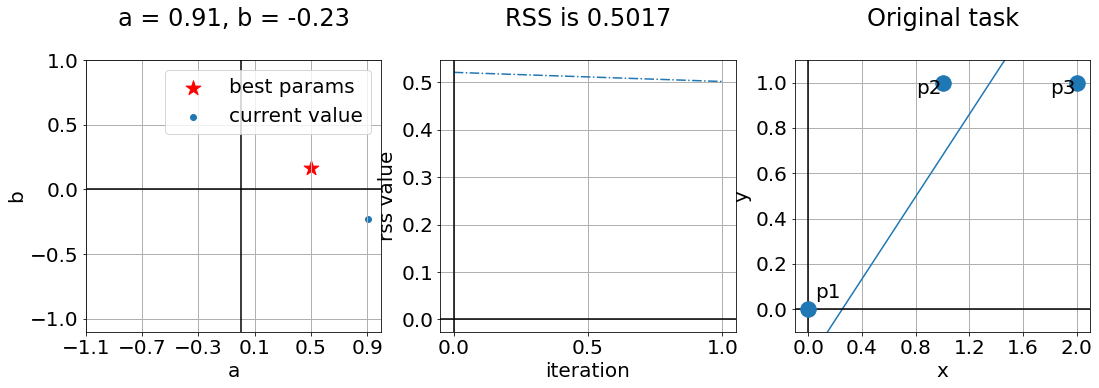

In [9]:
next(gradient_descent_step_generator)

#### Визуализация шагов ГС

Примеры спуска.
- на левом графике видно как меняются параметры a и b в сторону оптимальных значений
- в центре - сокращение значения целевой функции
- справа - как прямая линия подгоняется под исходные 3 точки

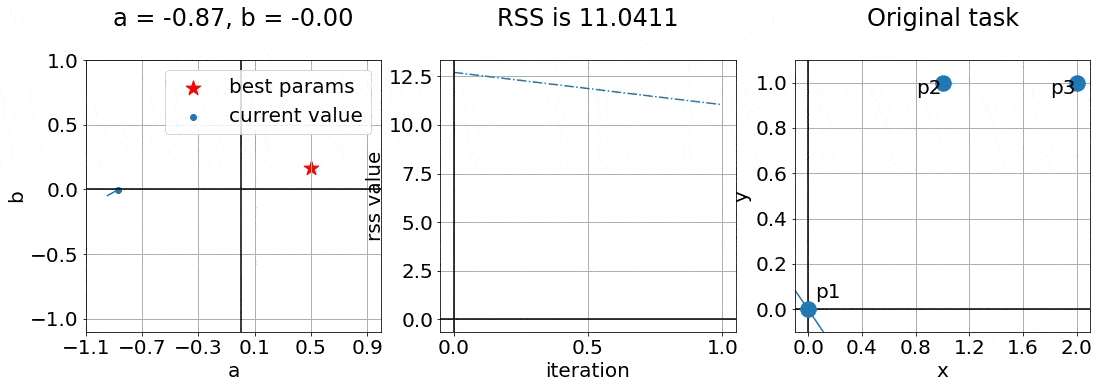

In [10]:
Image(open('./../gifs/01.gif','rb').read())

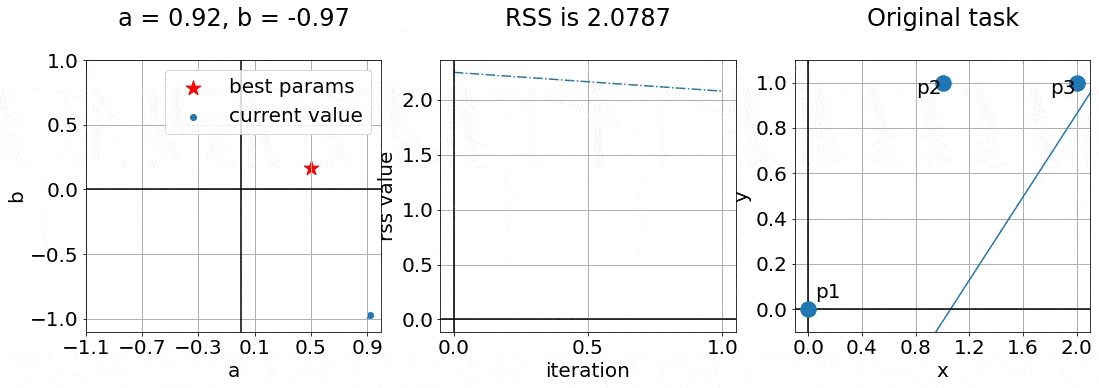

In [11]:
Image(open('./../gifs/03.gif','rb').read())

#### Проверка решения

Воспользуемся моделью линейной регрессии из scikit-learn для проверки найденного выше решения.

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
print(x)
print()
print(y)

[[0.]
 [1.]
 [2.]]

[[0.]
 [1.]
 [1.]]


In [14]:
%%time
lr = LinearRegression()
lr.fit(x, y)

CPU times: user 0 ns, sys: 615 µs, total: 615 µs
Wall time: 2.11 ms


LinearRegression()

In [15]:
print('a = ', f'{lr.coef_[0, 0]:.2f}')
print('b = ', f'{lr.intercept_[0]:.2f}')
print()
print(f'y(x) = {lr.coef_[0, 0]:.2f}x + {lr.intercept_[0]:.2f}')

a =  0.50
b =  0.17

y(x) = 0.50x + 0.17


Решение идентичное.

### Способы вычисления градиентов

Устройство фреймворка Keras:

![](https://www.digikey.com/maker-media/6c3d4f5f-98e0-4104-ad8c-fb0b47000109)

- BLAS - стандарт для создания библиотек, выполняющих основные операции лин. алгебры
- Eigen - библиотека лин. алгебры для С++
- CUDA - программно-аппартная архитектура параллельных вычислений
- cuDNN - библиотека примитивов для глубоких нейронных сетей
- TensorFlow - предоставляет инфраструктуру манипулирования тензорами: тензор, переменная, автоматическое дифференцирование, распараллеливание вычислений, ...
- Keras - библиотека разработки моделей глубокого обучения: модели, слои, оптимизаторы, лоссы, метрики

Исходная целевая функция:

$$ \Large f(a, b) = 5a^2 + 3b^2 -6a - 4b + 6ab + 2$$

Способы взятия частных производных:
- ручное дифференцирование
- конечно-разностное приближение (численная апроксимация производной)
- автоматическое дифференцирование в обратном режиме

#### Ручное дифференцирование

Частные производные функции считаются на листочке)

In [16]:
def f(a: float, b: float) -> float:
    ''' Целевая функция '''
    return 5*a**2 + 3*b**2 - 6*a - 4*b + 6*a*b + 2

def df_da(a: float, b: float) -> float:
    ''' Частная производная целевой функции по a '''
    return 10*a - 6 + 6*b

def df_db(a: float, b: float) -> float:
    ''' Частная производная целевой функции по b '''
    return 6*b - 4 + 6*a

Посчитаем значения частных производных при a = 1 и b = 1

In [17]:
a = 1.0
b = 1.0

print('df_da =', df_da(a, b))
print('df_db =', df_db(a, b))

df_da = 10.0
df_db = 8.0


cons:
- в реальных НС обычно сотни тысяч параметров, поэтому задача нахождения частных производных аналитически - невыполнима
- высока вероятность допутсить ошибку

#### Конечно-разностное приближение

Если из определения производной убрать предел.

$$ \large f'(x) = \lim_{\Delta x\to0} \frac{f(x + \Delta x) - f(x)}{\Delta x}$$

Также посчитаем значения частных производных при a = 1 и b = 1

In [18]:
eps = 1e-6

df_da_ = (f(a + eps, b) - f(a, b)) / eps
df_db_ = (f(a, b + eps) - f(a, b)) / eps

print('df_da =', df_da_)
print('df_db =', df_db_)

df_da = 10.000005000065926
df_db = 8.00000299872039


pros:
- лёгкая реализация

cons:
- функцию f необходимо вызвать хотя бы один раз на параметр
- даёт лишь приближение, для более сложных функций становится более худшим

#### Автоматическое дифференцирование в обратном порядке

TensorFlow будет считать производные за нас.

In [19]:
import tensorflow as tf

In [20]:
a = tf.Variable(1.0)
b = tf.Variable(1.0)

# создаём контекст ленты в виде ленты, которая будет автоматически регистрировать каждую операцию,
# которая задействует переменную, и в заключение запрашиваем у ленты вычисление градиентов результата z
# относительно обеих переменных a и b, которые соответственно равны 1.
with tf.GradientTape() as tape:
    z = f(a, b)
    
df_da_, df_db_ = tape.gradient(z, [a, b])

print('df_da =', df_da_)
print('df_db =', df_db_)

df_da = tf.Tensor(10.0, shape=(), dtype=float32)
df_db = tf.Tensor(8.0, shape=(), dtype=float32)


Частные производные в точке a = 1 и b = 1 всё так же равны 10 и 8 соответственно.

Пример графа вычислений, построенного TensorFlow:

![](https://www.pyimagesearch.com/wp-content/uploads/2020/03/keras_gradienttape_automatic_differentiation.png)

### Линейная регрессия

#### TensorFlow

Входные данные:

In [21]:
x = tf.constant([[0.0, 1.0, 2.0]])
y = tf.constant([[0.0, 1.0, 1.0]])

Модель линейной регрессии:

$$\Large y(x) = a \cdot x + b$$

In [22]:
# начальная инициализация переменных a и b
a = tf.Variable([[1.0]])
b = tf.Variable([[1.0]])

# декоратор @tf.function генерирует эквивалентный вычислительный граф
# в результате функция tensorflow выполняется гораздо быстрее функции python
# особенно если она производит сложные вычисления

@tf.function
def linear_model(x, a, b):
    ''' Задаём линейную функцию '''
    return tf.add(tf.matmul(a, x), b)

@tf.function
def residual_sum_of_squares(y_true, y_pred):
    ''' Задаём лосс-функцию '''
    return tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))

optimizer = tf.optimizers.SGD(learning_rate=0.1)

Совершаем 40 шагов градиентного спуска

In [23]:
nepochs = 40

for epoch in range(nepochs):
    with tf.GradientTape() as tape:
        rss = residual_sum_of_squares(y, linear_model(x, a, b))

    gradients = tape.gradient(rss, [a, b])
    optimizer.apply_gradients(zip(gradients, [a, b]))
    
    print(
        '{epoch:03d} / {nepochs}: rss = {rss:06.3f}, a = {a:+.3f}, b = {b:+.3f}'.format(
            epoch=epoch,
            nepochs=nepochs,
            rss=rss.numpy(),
            a=a.numpy()[0, 0],
            b=b.numpy()[0, 0],
        )
    )
    
print()    
print(f'y(x) = {a.numpy()[0, 0]:.2f}x + {b.numpy()[0, 0]:.2f}')

000 / 40: rss = 06.000, a = -0.000, b = +0.200
001 / 40: rss = 01.320, a = +0.480, b = +0.480
002 / 40: rss = 00.426, a = +0.312, b = +0.304
003 / 40: rss = 00.245, a = +0.418, b = +0.334
004 / 40: rss = 00.202, a = +0.399, b = +0.283
005 / 40: rss = 00.188, a = +0.430, b = +0.274
006 / 40: rss = 00.181, a = +0.436, b = +0.251
007 / 40: rss = 00.176, a = +0.449, b = +0.239
008 / 40: rss = 00.173, a = +0.457, b = +0.226
009 / 40: rss = 00.171, a = +0.464, b = +0.217
010 / 40: rss = 00.170, a = +0.470, b = +0.208
011 / 40: rss = 00.169, a = +0.475, b = +0.201
012 / 40: rss = 00.168, a = +0.479, b = +0.195
013 / 40: rss = 00.168, a = +0.483, b = +0.191
014 / 40: rss = 00.167, a = +0.486, b = +0.187
015 / 40: rss = 00.167, a = +0.488, b = +0.183
016 / 40: rss = 00.167, a = +0.490, b = +0.180
017 / 40: rss = 00.167, a = +0.492, b = +0.178
018 / 40: rss = 00.167, a = +0.493, b = +0.176
019 / 40: rss = 00.167, a = +0.494, b = +0.175
020 / 40: rss = 00.167, a = +0.495, b = +0.173
021 / 40: rss

#### Keras

In [24]:
from tensorflow.keras import initializers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model

Зададим входные данные

In [25]:
x = tf.constant([[0.0], [1.0], [2.0]])
y = tf.constant([[0.0], [1.0], [1.0]])

Вспомним схему обучения нейронной сети

![](https://drek4537l1klr.cloudfront.net/allaire/v-1/Figures/deep-learning-in-3-figures-3.png)

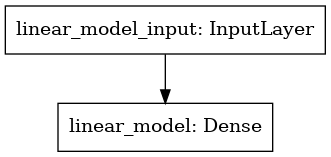

In [26]:
# создаём линейную модель, состоящую из одного нейрона
linear_model = models.Sequential(
    [
        layers.Dense(
            units=1,
            input_shape=(1, ),
            kernel_initializer=initializers.constant(1.0),
            bias_initializer=initializers.constant(1.0),
            name='linear_model',
        )
    ]
)

linear_model.compile(
    optimizer=optimizers.SGD(learning_rate=0.1, momentum=0.0),
    loss='mse',
)

plot_model(linear_model)

![](https://hsto.org/files/6e8/181/7ce/6e81817ce6bc4452ab1dd3ff9b74ec77.png)

In [27]:
# обучаем модель
linear_model.fit(x, y, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 111ms/step - loss: 2.0000
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6119
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.2301
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1234
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0921
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0816
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0770
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0742
Epoch 9/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0720
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0702
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0686
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0672
Epoch 13/100
1/1 [==============================] - 0s 2ms/

In [28]:
a, b = linear_model.get_weights()

print(f'y(x) = {a[0, 0]:.2f}x + {b[0]:.2f}')

y(x) = 0.50x + 0.17


Получаем ровно ту же самую прямую.

Закрепим схему обучения НС:

![](https://drek4537l1klr.cloudfront.net/allaire/v-1/Figures/deep-learning-in-3-figures-3.png)

#### Модификации градиентного спуска

![](../pics/03_gd_modification_descriprions.png)

![](../pics/02_gd_modification.png)

[Визуализация модификаций градиентного спуска](https://imgur.com/a/Hqolp#NKsFHJb)